# Encontrando a melhor acomodação em Limeira - SP

## Geolocalização

In [ ]:
from geopy.geocoders import Nominatim
import geopy

In [ ]:
geolocator = Nominatim(user_agent="myGeocoder")

In [ ]:
location = geolocator.geocode("Av. Cônego Manoel Alves, Limeira, Brazil")

print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

Avenida Cônego Manoel Alves, Limeira, Região Imediata de Limeira, Região Geográfica Intermediária de Campinas, São Paulo, Região Sudeste, 13484495, Brasil
(-22.5477236, -47.4505784)
{'place_id': 251868069, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 844960560, 'boundingbox': ['-22.5478199', '-22.5474753', '-47.4508295', '-47.4502269'], 'lat': '-22.5477236', 'lon': '-47.4505784', 'display_name': 'Avenida Cônego Manoel Alves, Limeira, Região Imediata de Limeira, Região Geográfica Intermediária de Campinas, São Paulo, Região Sudeste, 13484495, Brasil', 'class': 'highway', 'type': 'tertiary', 'importance': 0.61}


## Webscraping

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd

In [ ]:
url = 'https://www.guiamais.com.br/bairros/limeira-sp'
response = urlopen(url)
html_bairros_limeira = response.read()
soup_bairros_limeira = BeautifulSoup(html_bairros_limeira, 'html.parser')

In [ ]:
bairros = []

for bairro in soup_bairros_limeira.find('section', {'class': 'cities'}).find_all('a'):
  bairros.append(bairro.get_text())

bairros = pd.Series(bairros)
print(bairros)

0                     Anavec
1      Área Rural de Limeira
2            Bairro da Geada
3           Bairro dos Lopes
4           Bairro dos Pires
               ...          
247            Vila São João
248            Vila São Luiz
249           Vila São Roque
250               Vila Solar
251    Vila Teixeira Marques
Length: 252, dtype: object


In [ ]:
bairros_df = []
lats = []
longs = []

for bairro in bairros:
  location = geolocator.geocode(f"{bairro}, Limeira, São Paulo, Brazil")

  if location is not None:
    bairros_df.append(bairro)
    lats.append(location.latitude)
    longs.append(location.longitude)
    #print(location.address)

In [ ]:
df_bairros = pd.DataFrame()
df_bairros['bairro'] = bairros_df
df_bairros['lat'] = lats
df_bairros['lon'] = longs

df_bairros.head()

,bairro,lat,lon
0,Boa Vista,-22.613484,-47.546258
1,Centro,-22.565492,-47.403798
2,Chácara Antonieta,-22.555338,-47.436975
3,Chácara São José,-22.581140,-47.397673
4,Doutor João Batista Levy,-22.573660,-47.403187


In [ ]:
print(f'Foram encontrados {len(df_bairros)} bairros')

Foram encontrados 43 bairros


## Tratamento dos dados de Bairro

In [ ]:
df_bairros['address'].iloc[30]

'Praça Unicamp, Jardim Nossa Senhora de Fátima, Limeira, Região Imediata de Limeira, Região Geográfica Intermediária de Campinas, São Paulo, Região Sudeste, Brasil'

In [ ]:
!pip install unidecode

     |████████████████████████████████| 235 kB 10.8 MB/s 


In [ ]:
def insertRowToDF(df, row):
  row_sr = pd.Series(row, index=['bairro', 'lat', 'lon'])

  row_df = pd.DataFrame([row_sr])
  df = pd.concat([row_df, df], ignore_index=True)
  return df

def checkBairro(df, bairros_to_check):
  bairros = df_bairros['bairro'].map(lambda x: unidecode.unidecode(x).lower()).unique()
  bairros_to_check = list(map(lambda x: unidecode.unidecode(x).lower(), bairros_to_check))
  checksResult = []

  for bairro in bairros_to_check:
    checksResult.append(bairro in bairros)

  checks = pd.Series(checksResult, index=bairros_to_check)
  return checks

### Checando bairros existentes

In [ ]:
bairros_to_check = ['jardim nova italia', 
                    'jardim paulista', 
                    'jardim sao paulo', 
                    'jardim morro azul', 
                    'jardim esmeralda',
                    'jardim perola',
                    'chacara antonieta',
                    'cidade universitaria',
                    'jardim santa fe',
                    'jardim nossa sra. de fatima',
                    'vila santa josefa',
                    'jardim santa cecilia',
                    'vila esteves',
                    'vila santa rosalia',
                    'parque real',
                    'vila sao joao',
                    'vila mathias',
                    'vila anita',
                    'parque sao bento',
                    'parque centreville',
                    'jardim aquarius',
                    'vila rocha']

series_bairros_check = checkBairro(df_bairros, bairros_to_check)
series_bairros_check

jardim nova italia             False
jardim paulista                False
jardim sao paulo                True
jardim morro azul              False
jardim esmeralda               False
jardim perola                  False
chacara antonieta               True
cidade universitaria           False
jardim santa fe                False
jardim nossa sra. de fatima    False
vila santa josefa               True
jardim santa cecilia            True
vila esteves                    True
vila santa rosalia             False
parque real                     True
vila sao joao                  False
vila mathias                   False
vila anita                     False
parque sao bento               False
parque centreville             False
jardim aquarius                False
vila rocha                     False
dtype: bool

In [ ]:
series_bairros_check[series_bairros_check == False]

jardim nova italia             False
jardim paulista                False
jardim morro azul              False
jardim esmeralda               False
jardim perola                  False
cidade universitaria           False
jardim santa fe                False
jardim nossa sra. de fatima    False
vila santa rosalia             False
vila sao joao                  False
vila mathias                   False
vila anita                     False
parque sao bento               False
parque centreville             False
jardim aquarius                False
vila rocha                     False
dtype: bool

In [ ]:
len(series_bairros_check[series_bairros_check == False])

16

### Inserindo localização de bairros

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['jardim nova italia', -22.559177655613762, -47.42176126705203])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['jardim paulista', -22.558299143228314, -47.42619275210369])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['jardim morro azul', -22.5584169798876, -47.43045410500301])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['jardim esmeralda', -22.564260676816346, -47.435532311315484])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['jardim perola', -22.563011669111834, -47.438237176617655])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['cidade universitaria', -22.553112082481263, -47.433785919560094])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['jardim santa fe', -22.565597998868245, -47.422697294285875])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['jardim nossa sra. de fatima', -22.56550370773466, -47.426499662401234])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['vila santa rosalia', -22.576232119192287, -47.406309958879994])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['vila sao joao', -22.563403058144573, -47.41099287617916])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['vila mathias', -22.560899389858037, -47.41035742731719])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['vila anita', -22.556810220964934, -47.410568487120784])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['parque sao bento', -22.552056052471702, -47.41803295839295])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['parque centreville', -22.551580463658322, -47.42222150033637])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['jardim aquarius', -22.550608190589706, -47.41667575205869])

In [ ]:
df_bairros = insertRowToDF(df_bairros, ['vila rocha', -22.577951583104493, -47.410891226604896])

In [ ]:
df_bairros.head()

,bairro,lat,lon
0,vila rocha,-22.577952,-47.410891
1,jardim aquarius,-22.550608,-47.416676
2,parque centreville,-22.551580,-47.422222
3,parque sao bento,-22.552056,-47.418033
4,vila anita,-22.556810,-47.410568


In [ ]:
df_bairros.tail()

,bairro,lat,lon
54,Vila Cristovam,-22.574562,-47.404341
55,Vila Esteves,-22.573943,-47.408772
56,Vila Santa Josefa,-22.566830,-47.417376
57,Vila Santa Lina,-22.575128,-47.401097
58,Vila Solar,-22.582342,-47.397852


In [ ]:
print(f'Foram encontrados {len(df_bairros)} bairros')

Foram encontrados 59 bairros


In [ ]:
import geopy.distance

coords_ft_unicamp = (-22.561883227911103, -47.42418079671464)
distances = []

for i in range(len(df_bairros)):
  coords_aux = df_bairros.iloc[i, 1:]
  dist = geopy.distance.vincenty(coords_ft_unicamp, coords_aux).km
  distances.append(dist)

In [ ]:
df_bairros['dist'] = distances
df_bairros.head()

,bairro,lat,lon,dist
0,vila rocha,-22.577952,-47.410891,2.243706
1,jardim aquarius,-22.550608,-47.416676,1.467927
2,parque centreville,-22.551580,-47.422222,1.158567
3,parque sao bento,-22.552056,-47.418033,1.258614
4,vila anita,-22.556810,-47.410568,1.508559


In [ ]:
df_bairros.describe()

,lat,lon,dist
count,59.000000,59.000000,59.000000
mean,-22.572530,-47.413485,2.785695
std,0.019782,0.023772,2.350737
min,-22.651307,-47.546258,0.075333
25%,-22.582414,-47.421991,1.376103
50%,-22.570169,-47.410568,2.476853
75%,-22.562740,-47.402476,3.523261
max,-22.511194,-47.352932,13.792657


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

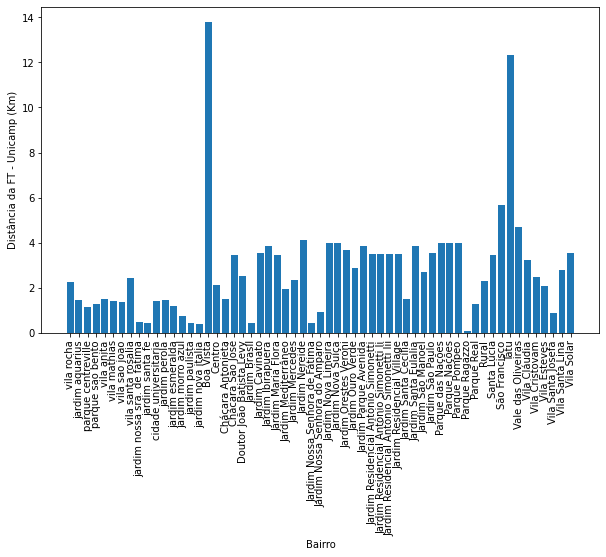

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(df_bairros['bairro'], df_bairros['dist'])
plt.xlabel('Bairro')
plt.ylabel('Distância da FT - Unicamp (Km)')
plt.xticks(rotation=90)

plt.show()

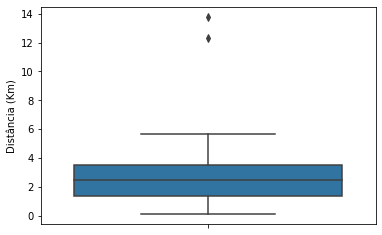

In [ ]:
sns.boxplot(y='dist', data=df_bairros)
plt.ylabel('Distância (Km)')
plt.show()

In [ ]:
df_bairros = df_bairros[df_bairros['dist'] < 7]
df_bairros.head()

,bairro,lat,lon,dist
0,vila rocha,-22.577952,-47.410891,2.243706
1,jardim aquarius,-22.550608,-47.416676,1.467927
2,parque centreville,-22.551580,-47.422222,1.158567
3,parque sao bento,-22.552056,-47.418033,1.258614
4,vila anita,-22.556810,-47.410568,1.508559


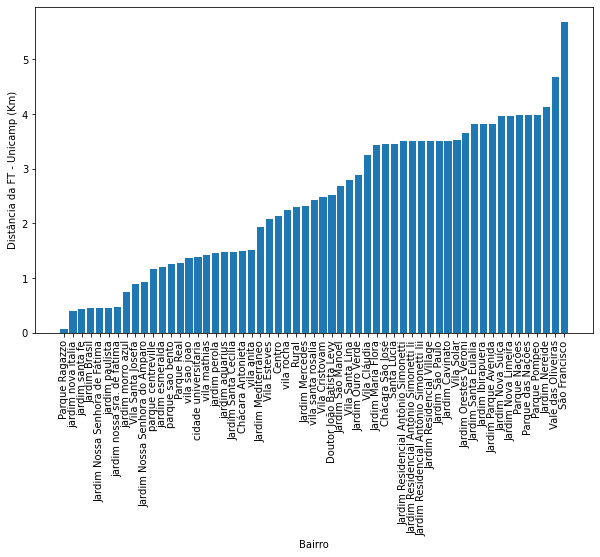

In [ ]:
df_bairros_sorted = df_bairros.sort_values(by='dist')

plt.figure(figsize=(10, 6))
plt.bar(df_bairros_sorted['bairro'], df_bairros_sorted['dist'])
plt.xlabel('Bairro')
plt.ylabel('Distância da FT - Unicamp (Km)')
plt.xticks(rotation=90)

plt.show()

## Pontos de ônibus

In [ ]:
url = 'https://moovitapp.com/index/pt-br/transporte_p%C3%BAblico-line-02_OLGA_VERONI_X_GEADA-Limeira-4161-908539-743590-0'
response = urlopen(url)
html_linhas_onibus = response.read()
soup_linhas_onibus = BeautifulSoup(html_linhas_onibus, 'html.parser')

In [ ]:
pontos = []

for ponto in soup_linhas_onibus.find('ul', {'class': 'stops-list bordered'}).find_all('h3'):
  pontos.append(ponto.get_text())

In [ ]:
pontos = pd.Series(pontos)
pontos = pontos.unique()
pontos

array(['Ponto Final Geada', 'Rua Elza Hergert Marostegan',
       'Avenida Prefeito Ari Levi Pereira, 368-408',
       'Avenida Canadá, 456-504',
       'Avenida Estados Unidos Da América, 52-100',
       'Rua Capitão Joaquim Manoel Pereira, 333-373',
       'Avenida Doutor João Amaral Gama, 575-633',
       'Avenida Doutor João Amaral Gama, 391 (Rapidão)',
       'Rua Júlio Wenzel, 641-655',
       'Rua Professor Rui Côrte Brilho, 816-880',
       'Rua Oscár Vargas, 17-87', 'Rua Oswaldo Bertolini, 505',
       'Praça Primeiro De Maio, 112-146',
       'Avenida Cônego Manoel Alves, 775',
       'Norte Avenida Doutor Fabrício Vampré, 975-991',
       'Norte Avenida Doutor Fabrício Vampré, 685',
       'Norte Avenida Doutor Fabrício Vampré, 131-181',
       'Rua Capitão Francisco Sérgio De Toledo, 145-207', 'Nosso Clube',
       'Medical B/C', 'Rua Barão De Campinas, 1027',
       'Escola Brasil - Praça José Bonifácio B/C',
       'Rua Barão De Campinas, 301', 'Terminal Central De Limeir

In [ ]:
lat = []
lon = []

for ponto in pontos:
  location = geolocator.geocode(f"{ponto}, Limeira, Brazil")
  if location == None:
    coords = input(f"Digite a coordenada de '{ponto}' (x, y): ")
    coords = coords.split(',')
    coords = (float(coords[0]), float(coords[1]))
    lat.append(coords[0])
    lon.append(coords[1])
  else:
    lat.append(location.latitude)
    lon.append(location.longitude)

Digite a coordenada de 'Ponto Final Geada' (x, y): -22.54534799380873, -47.45448054085058
Digite a coordenada de 'Avenida Doutor João Amaral Gama, 391 (Rapidão)' (x, y): -22.558555444439218, -47.442630355315096
Digite a coordenada de 'Rua Professor Rui Côrte Brilho, 816-880' (x, y): -22.561134208423862, -47.43595336973164
Digite a coordenada de 'Norte Avenida Doutor Fabrício Vampré, 975-991' (x, y): -22.559066875118823, -47.4229054440875
Digite a coordenada de 'Norte Avenida Doutor Fabrício Vampré, 685' (x, y): -22.558620803921194, -47.42013176091486
Digite a coordenada de 'Norte Avenida Doutor Fabrício Vampré, 131-181' (x, y): -22.560728231386136, -47.41555660069769
Digite a coordenada de 'Rua Capitão Francisco Sérgio De Toledo, 145-207' (x, y): -22.558197007552785, -47.412828403187596
Digite a coordenada de 'Nosso Clube' (x, y): -22.558720436605455, -47.409808033403905
Digite a coordenada de 'Escola Brasil - Praça José Bonifácio B/C' (x, y): -22.561011950736074, -47.40396744752847
Di

In [ ]:
'''
-22.54534799380873, -47.45448054085058
-22.558555444439218, -47.442630355315096
-22.561134208423862, -47.43595336973164
-22.559066875118823, -47.4229054440875
-22.558620803921194, -47.42013176091486
-22.560728231386136, -47.41555660069769
-22.558197007552785, -47.412828403187596
-22.558720436605455, -47.409808033403905
-22.561011950736074, -47.40396744752847
-22.569341176363963, -47.400102804456175
-22.577078622765704, -47.39148226761585
-22.581854394170282, -47.38515237650475
-22.579961253882317, -47.381879508771206
-22.581196104338872, -47.36869089689841
'''

In [ ]:
df_ponto_02 = pd.DataFrame()
df_ponto_02['ponto'] = pontos
df_ponto_02['lat'] = lat
df_ponto_02['lon'] = lon

df_ponto_02.head()

,ponto,lat,lon
0,Ponto Final Geada,-22.545348,-47.454481
1,Rua Elza Hergert Marostegan,-22.545483,-47.451153
2,"Avenida Prefeito Ari Levi Pereira, 368-408",-22.550156,-47.451575
3,"Avenida Canadá, 456-504",-22.549483,-47.447750
4,"Avenida Estados Unidos Da América, 52-100",-22.552190,-47.448299


In [ ]:
print(f'Foram encontrados {len(df_ponto_02)} pontos de ônibus')

Foram encontrados 44 pontos de ônibus


In [ ]:
import folium
from pprint import pprint

# Criação do mapa
map = folium.Map(location=[-22.56508562812944, -47.40434392781407], tiles='cartodbpositron', zoom_start=20)

# Tooltip
tooltip_acomodacao = "Clique para ver o nome do ponto"

# Markers
for i in range(len(df_ponto_02)):
  folium.Marker(df_ponto_02.iloc[i, 1:], popup=f"<i>Ponto {i+1}: {df_ponto_02.iloc[i, 0]}</i>", tooltip=tooltip_acomodacao,icon=folium.Icon(color="blue", icon="bus", prefix='fa')).add_to(map)

map